## 一个问题

- y_train不能使用one-hot编码

## 图片预览

In [1]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

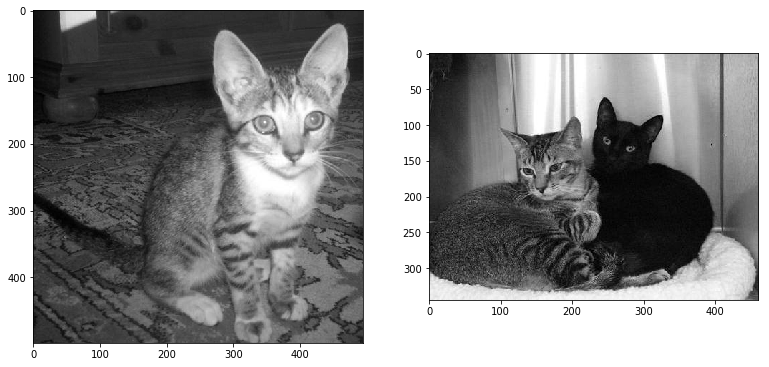

In [33]:
# 查看两张图片
img_path1 = "./dogs_cats/cat.7.jpg"
img_check1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
img_path2 = "./dogs_cats/cat.8.jpg"
img_check2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
# 显示图片
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,7))
axes[0].imshow(img_check1,'gray')
axes[1].imshow(img_check2,'gray')

## 图片处理

- 所有图片处理为64*64的灰度图

In [67]:
# 处理图片
def image_label(image):
    """对图片进行独热标记-输入的是文件名
    """
    label = image.split('.')[-3]
    if label == 'cat':
        # return [1, 0]
        return 1
    elif label == 'dog':
        return 0

def image_preprocess(dir_path='./dogs_cats/'):
    """图片预处理
    """
    data = []
    i = 0
    for img in tqdm(os.listdir(dir_path)): # 调用 tqdm 可视化循环处理过程
        img_path = os.path.join(dir_path, img)
        img_data = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 使用 opencv 将图片处理成灰度矩阵
        img_data = cv2.resize(img_data, (64, 64)) # 图片处理成统一大小
        data.append([np.array(img_data), image_label(img)]) # 保存图片矩阵信息及图片标签
        i = i + 1
        if i%5000 == 0:
            print('i:',i,'img_name:',img,image_label(img))
    random.shuffle(data) # 随机打乱,直接打乱data
    np.save('dogs_cats.npy', data) # 存放处理后的 numpy 数组，方便下次使用
    return data

In [68]:
image_data = image_preprocess()

 20%|███████████████▏                                                            | 4994/25000 [00:40<02:22, 140.72it/s]

i: 5000 img_name: cat.3247.jpg 1


 40%|██████████████████████████████▍                                             | 9999/25000 [01:18<01:47, 139.30it/s]

i: 10000 img_name: cat.7748.jpg 1


 60%|████████████████████████████████████████████▉                              | 14985/25000 [01:54<01:25, 117.32it/s]

i: 15000 img_name: dog.12246.jpg 0


 80%|███████████████████████████████████████████████████████████▉               | 19993/25000 [02:32<00:38, 128.79it/s]

i: 20000 img_name: dog.5498.jpg 0


100%|██████████████████████████████████████████████████████████████████████████▉| 24998/25000 [03:09<00:00, 137.89it/s]

i: 25000 img_name: dog.9999.jpg 0


100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:09<00:00, 131.63it/s]


In [70]:
# 查看处理后的数据
# image_data[i][0]表示图片像素矩阵
# image_data[i][1]表示是cat([1,0]) or dog([0,1])
image_data[1]

[array([[112, 111, 108, ...,  52,  43,  50],
        [102, 104, 102, ...,  53,  43,  51],
        [115, 112, 111, ...,  54,  43,  51],
        ...,
        [102, 102,  96, ...,  27,  32,  49],
        [ 97,  94,  85, ...,  25,  25,  49],
        [ 81,  82,  86, ...,  29,  22,  46]], dtype=uint8), 1]

In [3]:
# 直接读取npy的数据
image_data = np.load('./dogs_cats.npy')

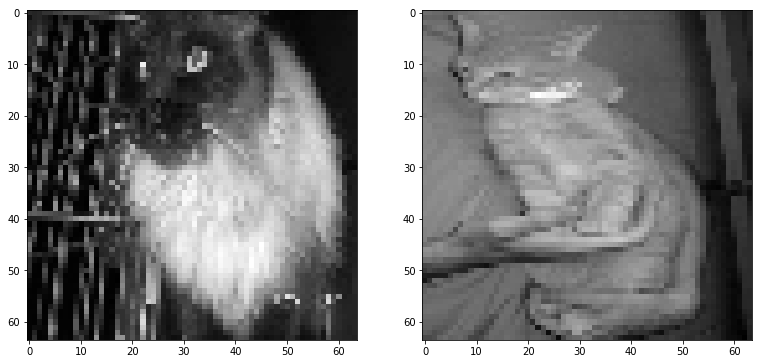

In [4]:
# 显示图片-图像处理后的图片
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,7))
axes[0].imshow(image_data[0][0],'gray')
axes[1].imshow(image_data[1][0],'gray')

## 划分训练集与测试集

In [5]:
# 测试集与训练集的划分
train_data = image_data[:-5000] # 训练集
test_data = image_data[-5000:] # 测试集(测试集大小为5000)

# 测试集的输入输出和训练集的输入输出
X_train = np.array([i[0] for i in train_data]).reshape(-1, 1, 64, 64) # 训练集特征(变为64*64*1的矩阵)
y_train = np.array([i[1] for i in train_data]) # 训练集标签

X_test = np.array([i[0] for i in test_data]).reshape(-1, 1, 64, 64) # 测试集特征
y_test = np.array([i[1] for i in test_data]) # 测试集标签

len(X_train), len(y_train), len(X_test), len(y_test)

(20000, 20000, 5000, 5000)

In [23]:
# 上面reshape时-1的含义,即20000的含义
X_train.shape

(20000, 1, 64, 64)

## 网络的搭建

In [6]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

- 第一层卷积层，卷积核大小 $3\times3$，包含 32 个卷积核，same padding 形式，relu 激活；
- 第一层池化层，池化大小 $2\times2$， 步长为 1，valid padding 形式；
- 第二层卷积层，卷积核大小 $3\times3$，包含 64 个卷积核，same padding 形式，relu 激活；
- 第二层池化层，池化大小 $2\times2$，步长为 1，valid padding 形式；
- 第三层卷积层，卷积核大小 $3\times3$，包含 128 个卷积核，same padding 形式，relu 激活；
- 第三层池化层，池化大小 $2\times2$，步长为 2，valid padding 形式；
- 全连接层，128 的输出，注意要将第三层池化层平铺送入第一层全连接层；
- Dropout 层，概率设为 0.6

In [84]:
# 计算卷积后的矩阵大小
def cal_pad(inputNum, kernel, stride, padding):
    res = (inputNum+2*padding-(kernel-1)-1)/stride
    res = int(res)+1
    print(res)

In [94]:
cal_pad(28, 5, 1, 2)

28


In [7]:
# -------
# 定义网络
# -------
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        # 参数的定义
        # 卷积层+池化层
        self.conv = nn.Sequential(
            # 第一层
            nn.Conv2d(kernel_size=3, in_channels=1, out_channels=32, stride=1, padding=1), # (-1, 64, 64, 1)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            # 第二层
            nn.Conv2d(kernel_size=3, in_channels=32, out_channels=64, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
            # 第三层
            nn.Conv2d(kernel_size=3, in_channels=64, out_channels=128, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 全连接层
        self.line = nn.Sequential(
            nn.Linear(in_features=123008, out_features=128),
            nn.Dropout(p=0.6),
            nn.Linear(in_features=128, out_features=2)
        )
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #展开
        x = self.line(x)
        return x

# ------------
# 查看网络结构
# ------------
Cnn = cnn()
print(Cnn)

cnn(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (line): Sequential(
    (0): Linear(in_features=123008, out_features=128, bias=True)
    (1): Dropout(p=0.6)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 网络的训练

In [8]:
loss_fn = nn.CrossEntropyLoss() # 定义损失函数
optimiser = optim.Adam(params=Cnn.parameters(), lr=0.05) # 定义优化器

# 定义变量
X_train = torch.Tensor(X_train) # 输入 x 张量
X_test = torch.Tensor(X_test)
Y_train = torch.Tensor(y_train).long() # 输入 y 张量
Y_test = torch.Tensor(y_test).long()

In [25]:
X_train.shape

torch.Size([20000, 1, 64, 64])

In [26]:
Y_train.shape

torch.Size([20000, 2])

In [9]:
# 使用batch训练
import torch.utils.data as Data
torch_dataset = Data.TensorDataset(X_train, Y_train) # 合并训练数据和目标数据
MINIBATCH_SIZE = 25
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=4           # set multi-work num read data
)

In [10]:
# 开始训练
loss_list = [] # 用来保存每轮训练后的loss
for epoch in range(2):
    for step, (batch_x, batch_y) in enumerate(loader):
        batch_x = Variable(batch_x)
        batch_y = Variable(batch_y)
        # 前向传播
        out = Cnn(batch_x)
        loss = loss_fn(out, batch_y) # 计算损失
        # 梯度清零
        optimiser.zero_grad() 
        # 反向传播
        loss.backward()
        optimiser.step() # 随机梯度下降
        if step % 10 ==0:
            loss_list.append(loss)
            print("Epoch is {0}, Step is {1} Loss is {2}".format(epoch,step,loss))

Epoch is 0, Step is 0 Loss is 4.060680389404297
Epoch is 0, Step is 10 Loss is 52.497169494628906
Epoch is 0, Step is 20 Loss is 1.4986920356750488
Epoch is 0, Step is 30 Loss is 3.5506043434143066
Epoch is 0, Step is 40 Loss is 0.8484818339347839
Epoch is 0, Step is 50 Loss is 1.0982012748718262
Epoch is 0, Step is 60 Loss is 0.7854775786399841
Epoch is 0, Step is 70 Loss is 0.7699434757232666
Epoch is 0, Step is 80 Loss is 0.7678232789039612
Epoch is 0, Step is 90 Loss is 0.7513699531555176
Epoch is 0, Step is 100 Loss is 0.6745223999023438
Epoch is 0, Step is 110 Loss is 0.9967782497406006
Epoch is 0, Step is 120 Loss is 0.8213810920715332
Epoch is 0, Step is 130 Loss is 71.67991638183594
Epoch is 0, Step is 140 Loss is 0.7697029709815979
Epoch is 0, Step is 150 Loss is 0.6945238709449768
Epoch is 0, Step is 160 Loss is 0.733700156211853
Epoch is 0, Step is 170 Loss is 0.8051213622093201
Epoch is 0, Step is 180 Loss is 0.754300057888031
Epoch is 0, Step is 190 Loss is 2.545746088027

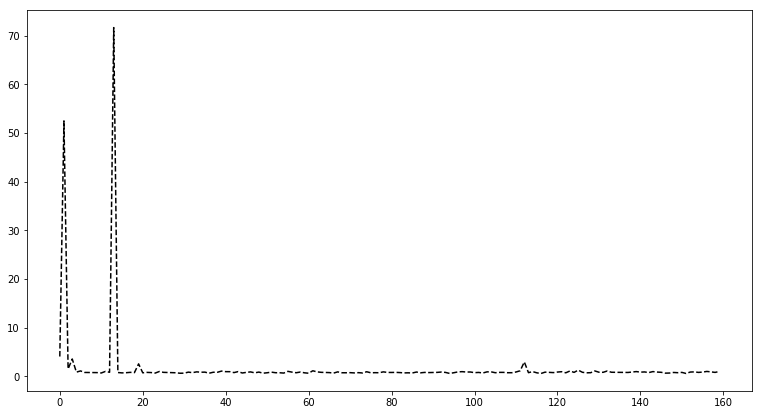

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(13,7))
axes.plot(loss_list, 'k--')

## 模型的保存于重载

In [37]:
# 只保存模型的参数
torch.save(Cnn.state_dict(),'cats_dogs_params.pkl')

In [9]:
# 重载模型参数
Cnn.load_state_dict(torch.load('cats_dogs_params.pkl'))

In [11]:
# 保存整个模型
torch.save(Cnn, 'cats_dogs_params.pth')  

c:\users\wmn\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type cnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# 加载整个模型
model = torch.load('model.pth') 

## 模型进行预测

In [17]:
X_test[0], Y_test[0]

(tensor([[[ 17.,  10.,  12.,  ...,  17.,  16.,   9.],
          [ 14.,  20.,  25.,  ...,  19.,  25.,  27.],
          [ 19.,  17.,  23.,  ...,  24.,  26.,  31.],
          ...,
          [ 80.,  88.,  96.,  ...,  41.,  42.,  43.],
          [ 80.,  88.,  99.,  ...,  26.,  22.,  22.],
          [ 75.,  82.,  91.,  ...,  35.,  28.,  26.]]]), tensor(1))

In [22]:
Cnn(X_train[0:10])

tensor([[ 0.3230, -0.3525],
        [-0.2681,  0.2780],
        [-0.4157,  0.3455],
        [ 0.4763, -0.5076],
        [-0.0900,  0.0420],
        [ 0.2395, -0.3689],
        [-0.0404, -0.0258],
        [-0.5711,  0.6267],
        [-0.0268,  0.0664],
        [-0.1613,  0.1515]], grad_fn=<ThAddmmBackward>)

In [10]:
pre = torch.max(Cnn(X_test[0:10]),1)[1].data.numpy().squeeze()
print("Predict:{0}".format(pre))
print("Real:{0}".format(Y_test[0:10]))

Predict:[1 1 0 1 0 1 0 1 0 0]
Real:tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0])


In [36]:
# 计算准确率
(torch.max(Cnn(X_test[0:100]),1)[1].data.numpy().squeeze()==Y_test[0:100].data.numpy()).sum()

44